# 5. How to Log and Visualize Simulations

Here we explain how to take a log of simulation results and how to visualize it. 

In [1]:
%matplotlib inline
import math
from ecell4 import *

## 5.1. Logging Simulations with Observers

E-Cell4 provides special classes for logging, named `Observer`. `Observer` class is given when you call the `run` function of `Simulator`.

In [2]:
def create_simulator(f=gillespie.GillespieFactory()):
    m = NetworkModel()
    A, B, C = Species('A', '0.005', '1'), Species('B', '0.005', '1'), Species('C', '0.005', '1')
    m.add_reaction_rule(create_binding_reaction_rule(A, B, C, 0.01))
    m.add_reaction_rule(create_unbinding_reaction_rule(C, A, B, 0.3))
    w = f.create_world()
    w.bind_to(m)
    w.add_molecules(C, 60)
    sim = f.create_simulator(w)
    sim.initialize()
    return sim

One of most popular `Observer` is `FixedIntervalNumberObserver`, which logs the number of molecules with the given time interval. `FixedIntervalNumberObserver` requires an interval and a list of serials of `Species` for logging.

In [3]:
obs1 = FixedIntervalNumberObserver(0.1, ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)

`data` function of `FixedIntervalNumberObserver` returns the data logged.

In [4]:
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 1.0, 1.0, 59.0], [0.2, 2.0, 2.0, 58.0], [0.30000000000000004, 2.0, 2.0, 58.0], [0.4, 3.0, 3.0, 57.0], [0.5, 5.0, 5.0, 55.0], [0.6000000000000001, 6.0, 6.0, 54.0], [0.7000000000000001, 7.0, 7.0, 53.0], [0.8, 8.0, 8.0, 52.0], [0.9, 13.0, 13.0, 47.0], [1.0, 15.0, 15.0, 45.0]]


`targets()` returns a list of `Species`, which you specified as an argument of the constructor.

In [5]:
print([sp.serial() for sp in obs1.targets()])

[u'A', u'B', u'C']


`NumberObserver` logs the number of molecules after every steps when a reaction occurs. This observer is useful to log all reactions, but not available for `ode`.

In [6]:
obs1 = NumberObserver(['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.04012025333035717, 1.0, 1.0, 59.0], [0.1432383168037779, 2.0, 2.0, 58.0], [0.20341797600055206, 3.0, 3.0, 57.0], [0.2600460824718564, 4.0, 4.0, 56.0], [0.4563313103191615, 5.0, 5.0, 55.0], [0.5528122166668636, 6.0, 6.0, 54.0], [0.615789495953695, 7.0, 7.0, 53.0], [0.6251575472817018, 8.0, 8.0, 52.0], [0.6599014280070172, 9.0, 9.0, 51.0], [0.7540135734955223, 10.0, 10.0, 50.0], [0.8153146235383694, 9.0, 9.0, 51.0], [0.8757846887604139, 10.0, 10.0, 50.0], [0.8955022695500489, 9.0, 9.0, 51.0], [0.9302001972345713, 10.0, 10.0, 50.0], [0.9677602837999943, 11.0, 11.0, 49.0], [1.0, 11.0, 11.0, 49.0]]


`TimingNumberObserver` allows you to give the times for logging as an argument of its constructor.

In [7]:
obs1 = TimingNumberObserver([0.0, 0.1, 0.2, 0.5, 1.0], ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 1.0, 1.0, 59.0], [0.2, 2.0, 2.0, 58.0], [0.5, 4.0, 4.0, 56.0], [1.0, 13.0, 13.0, 47.0]]


`run` function accepts multile `Observer`s at once.

In [8]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(1.0, [obs1, obs2])
print(obs1.data())
print(obs2.data())

[[0.0, 60.0], [0.04012025333035717, 59.0], [0.15926218274374596, 58.0], [0.39266371452545934, 57.0], [0.4089320745355458, 56.0], [0.4422009791923337, 55.0], [0.5585562269066001, 54.0], [0.6046043939535647, 53.0], [0.7924167906488757, 52.0], [0.8013379709207931, 51.0], [0.826487554344241, 50.0], [0.8310996056810509, 49.0], [0.8433700041987312, 48.0], [0.8720388256418109, 47.0], [0.8798241077684008, 46.0], [0.8852755964349587, 47.0], [0.9731675340005557, 46.0], [0.9841575657112053, 45.0], [1.0, 45.0]]
[[0.0, 0.0, 0.0], [0.1, 1.0, 1.0], [0.2, 2.0, 2.0], [0.30000000000000004, 2.0, 2.0], [0.4, 3.0, 3.0], [0.5, 5.0, 5.0], [0.6000000000000001, 6.0, 6.0], [0.7000000000000001, 7.0, 7.0], [0.8, 8.0, 8.0], [0.9, 13.0, 13.0], [1.0, 15.0, 15.0]]


`FixedIntervalHDF5Observedr` logs the whole data in a `World` to an output file with the fixed interval. Its second argument is a prefix for output filenames. `filename()` returns the name of a file scheduled to be saved next. At most one format string like `%02d` is allowed to use a step count in the file name. When you do not use the format string, it overwrites the latest data to the file.

In [9]:
obs1 = FixedIntervalHDF5Observer(0.2, 'data/test%02d.h5')
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

data/test00.h5
data/test06.h5


In [10]:
w = load_world('data/test05.h5')
print(w.t(), w.num_molecules(Species('C')))

(1.0, 47)


The usage of `FixedIntervalCSVObserver` is almost same with that of `FixedIntervalHDF5Observer`. It saves positions (x, y, z) of particles with the radius (r) and serial number of `Species` (sid) to a CSV file.

In [11]:
obs1 = FixedIntervalCSVObserver(0.2, "data/test%02d.csv")
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

data/test00.csv
data/test06.csv


Here is the first 10 lines in the output CSV file.

In [12]:
print(''.join(open("data/test05.csv").readlines()[: 10]))

x,y,z,r,sid
0.73971325345337391,0.30540283070877194,0.84695620532147586,0,0
0.74204347841441631,0.0079800731036812067,0.89030921366065741,0,0
0.33721050526946783,0.094076887238770723,0.20437641278840601,0,0
0.15352247771807015,0.95370534248650074,0.72450916958041489,0,0
0.13091015559621155,0.64815035578794777,0.20418494241312146,0,0
0.50311922095716,0.56134434207342565,0.88193057128228247,0,0
0.32995764771476388,0.35425997176207602,0.99539713468402624,0,0
0.49342488474212587,0.11331753432750702,0.56601206958293915,0,0
0.31956235598772764,0.45714963413774967,0.69531405507586896,0,0



For particle simulations, E-Cell4 also provides `Observer` to trace a trajectory of a molecule, named `FixedIntervalTrajectoryObserver`. When no `ParticleID` is specified, it logs all the trajectories. Once some `ParticleID` is lost for the reaction during a simulation, it just stop to trace the particle any more.

In [13]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalTrajectoryObserver(0.01)
sim.run(0.1, obs1)

In [14]:
print([tuple(pos) for pos in obs1.data()[0]])

[(0.4000833246545858, 0.16743157806499148, 0.17), (0.39191835884530857, 0.23382685902179845, 0.41500000000000004), (0.4082482904638631, 0.3377499074759311, 0.585), (0.4409081537009721, 0.35507041555161983, 0.355), (0.30210373494325865, 0.2540341184434353, 0.42), (0.19595917942265428, 0.20784609690826528, 0.46), (0.09797958971132714, 0.24248711305964282, 0.43), (-0.00816496580927728, 0.44455970727601185, 0.27), (0.10614455552060442, 0.33197640478403484, 0.295), (0.19595917942265428, 0.16454482671904336, 0.215), (0.27760883751542687, 0.14722431864335456, -0.10499999999999998)]


Generally, `World` assumes a periodic boundary for each plane. To avoid the big jump of a particle at the edge due to the boundary condition, `FixedIntervalTrajectoryObserver` tries to keep the shift of positions. Thus, the positions stored in the `Observer` are not necessarily limited in the cuboid given for the `World`. To track the diffusion over the boundary condition accurately, the step interval for logging must be small enough. Of course, you can disable this option. See `help(FixedIntervalTrajectoryObserver)`.

## 5.2. Visualization of Data Logged

In this section, we explain the visualization tools for data logged by `Observer`.

Firstly, for time course data, `viz.plot_number_observer` plots the data provided by `NumberObserver`, `FixedIntervalNumberObserver` and `TimingNumberObserver`. For the detailed usage of `viz.plot_number_observer`, see `help(viz.plot_number_observer)`.

In [15]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(10.0, [obs1, obs2])

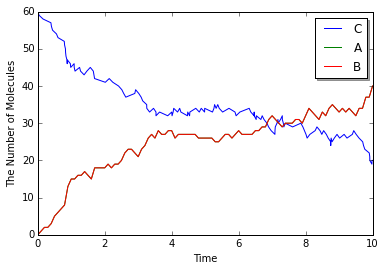

In [16]:
viz.plot_number_observer(obs1, obs2)

You can set the style for plotting, and even add an arbitrary function to plot.

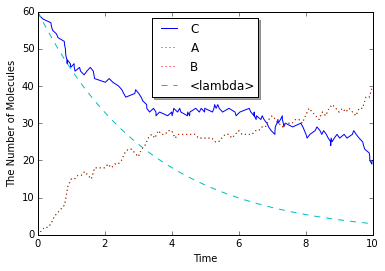

In [17]:
viz.plot_number_observer(obs1, '-', obs2, ':', lambda t: 60 * math.exp(-0.3 * t), '--')

Plotting in the phase plane is also available by specifing the x-axis and y-axis.

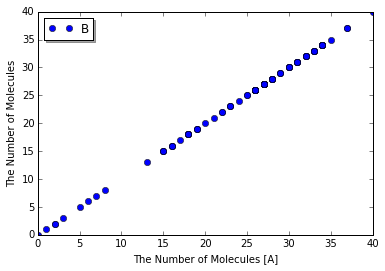

In [18]:
viz.plot_number_observer(obs2, 'o', x='A', y='B')

For spatial simulations, to visualize the state of `World`, `viz.plot_world` is available. This function plots the points of particles in three-dimensional volume in the interactive way. You can save the image by clicking a right button on the drawing region.

In [19]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
viz.plot_world(sim.world())

You can also make a movie from a series of HDF5 files, given as a `FixedIntervalHDF5Observer`. NOTE: `viz.plot_movie_with_matplotlib` requires an extra library, `ffmpeg`.

In [20]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalHDF5Observer(0.02, 'data/test%02d.h5')
sim.run(1.0, obs1)
viz.plot_movie_with_matplotlib(obs1)

Start generating species_list ...
Start preparing mplot3d ...
Start making animation ...
Start generating a movie ...


Finally, corresponding to `FixedIntervalTrajectoryObserver`, `viz.plot_trajectory` provides a visualization of particle trajectories.

In [21]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalTrajectoryObserver(1e-3)
sim.run(1, obs1)
viz.plot_trajectory(obs1)